<a href="https://colab.research.google.com/github/khalil753/Bio-Project/blob/master/DirtyTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting libraries and defining global variables**

In [0]:
import fastai
from fastai.vision import *
from fastai.widgets import *

import numpy as np
import pandas as pd

from pathlib import Path
import os
from os import listdir

import matplotlib as mpl
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(r"/content/gdrive/My Drive/Mestría en Física de Sistemas Complejos/Tercer semestre/Inference in Biological Systems/Project")
path_data = path/'data'
path_clean_losses = path_data/"Clean Losses"
path_losses = path_data/"Losses"

classes = ['healthy', 'tumor', 'injury']

model_folder = Path("Model 1")

# **Training the model**

In [0]:
finding_lr = True
training = True

## *Loading Data and Model* 

In [0]:
path_data = path/'data'
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_folder(path_data, ds_tfms=tfms, size=32,  
                                        train="train",
                                        valid="val",
                                        classes=classes, bs=100,
                                        num_workers=1).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, path=path_data)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


## *Finding the best Learning Rate*

In [0]:
if finding_lr:
  learn.lr_find()

In [0]:
if finding_lr:
  learn.recorder.plot()

## *Training the fully connected layers of the NN*

In [0]:
if training:
  learn.fit_one_cycle(15, max_lr=0.002)

In [0]:
if training: learn.save(model_folder/'stage-1')

## *Fine tuning the model*

In [0]:
if training: 
  learn.load(model_folder/'stage-1')
  learn.unfreeze()
  learn.fit_one_cycle(10, max_lr=slice(3e-5,3e-4))

In [0]:
if training: learn.save(model_folder/'stage-2')

Since the model without fine tuning was best:

In [0]:
if training:
  learn.load(model_folder/'stage-2')

# **Studying the Losses**

## *Calculating validation and training loss*

In [0]:
calculating_losses = False

In [0]:
if calculating_losses:
  val_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
  train_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

In [0]:
if calculating_losses:
  (val_losses, val_idxs), (train_losses, train_idxs) = val_interp.top_losses(), train_interp.top_losses()
  torch.save(train_losses, path_losses/'train_losses1.pt')
  torch.save(train_idxs, path_losses/'train_idxs1.pt')
  torch.save(val_losses, path_losses/'val_losses1.pt')
  torch.save(val_idxs, path_losses/'val_idxs1.pt')

## *Saving Predictions and Confusion Matrix*

We save the predictions to not have to recalculate them in the future

In [0]:
if calculating_losses:
  cm = val_interp.confusion_matrix()
  preds = val_interp.preds
  np.save(path_data/"Confusion Matrices"/"CM1", cm)
  np.save(path_data/"Preds"/"p1", preds)

## *Plotting Loss Histograms*

In [0]:
train_losses = torch.load(path_losses/'train_losses1.pt')
val_losses = torch.load(path_losses/'val_losses1.pt')
losses = [train_losses, val_losses]

train_idxs = torch.load(path_losses/'train_idxs1.pt')
val_idxs = torch.load(path_losses/'val_idxs1.pt')
losses = [train_losses, val_losses]
idxs = [train_idxs, val_idxs]

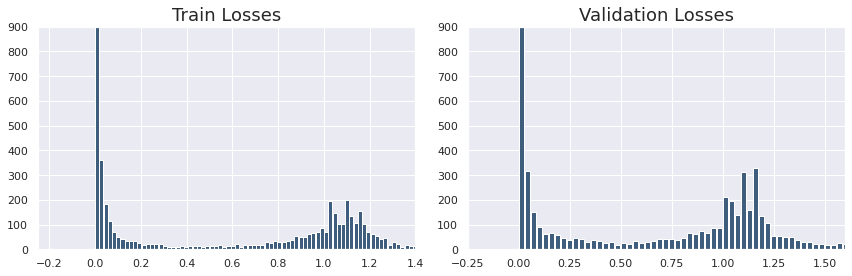

In [0]:
n_plots = 2
fig, ax = plt.subplots(1, n_plots, figsize = (6*n_plots,4))

xlims = [(-0.25,1.4), (-.25, 1.6)]
names = ["Train", "Validation"]
bins = [240, 300]
for name, loss, axis, xlim, b in zip(names, losses, ax, xlims, bins):
  axis.set_xlim(*xlim)
  axis.set_ylim(0,900)
  axis.set_title(name + " Losses", fontsize=18)
  hist = axis.hist(loss, bins=b, color="#3F5D7D", rwidth=.95)  
plt.tight_layout()
plt.show()
fig.savefig(path/"fig"/"Loss_Hist1.png")

## *Removing high loss images*

train: 9571/12335 = 78%
val: 4917/7308 = 67%


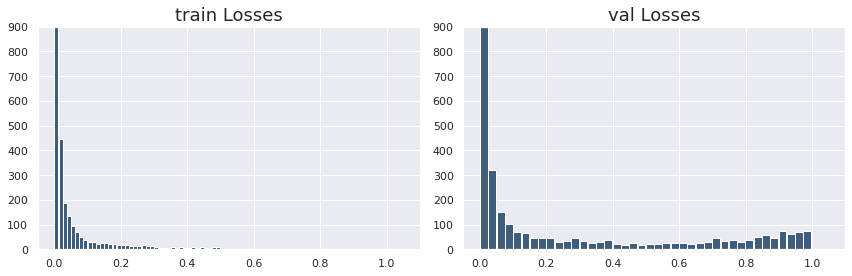

In [0]:
thresholds = [.5, 1]
dfs = [data.train_ds.to_df(), data.valid_ds.to_df()]
names = ["train", "val"]
is_valid = ["False", "True"]
n_plots = 2
fig, ax = plt.subplots(1, n_plots, figsize = (6*n_plots,4))

for loss, idx, th, df, name, is_val, axis  in zip (losses, idxs, thresholds, dfs, names, is_valid, ax):
  # Defining the "is_valid" column to define ImageLists from df later on
  df["is_valid"] = is_val
  n_good = (loss <= th).sum()

  # Plotting hists of low loss images
  axis.set_xlim(-0.05, 1.1)
  axis.set_ylim(0,900)
  axis.set_title(name + " Losses", fontsize=18)
  hist = axis.hist(loss[-n_good:], bins=40, color="#3F5D7D", rwidth=.95)  

  # Adding a column clean to indicate the low loss samples
  good_idx = idx[-n_good:]
  clean = np.zeros(len(df), dtype=bool)
  clean[good_idx] = True
  p = float(n_good)/len(df)*100
  print(f"{name}: {n_good}/{len(df)} = {p:0.0f}%")
  df["clean"] = clean
  df.to_csv(path_data/"Clean Data"/f"{name}.csv", index=False)

plt.tight_layout()
plt.show()